In [1]:
#imports
import time
from glob import glob 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Conv2DTranspose,BatchNormalization,Flatten,Dense,Reshape
from tensorflow.keras import activations 
from tensorflow.keras import optimizers 
import cv2
import math
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import random
from prettytable import PrettyTable
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

In [2]:
#global variables
EPOCHS=50
LR=1e-3
BATCH_SIZE=8

In [3]:
#link the google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/EE6310_course_project/train.zip

### comparative analysis


In [5]:
#calculate mse between two images
def mse(imageA,imageB):
    mse_error=np.sum((imageA.astype("float")-imageB.astype("float"))**2)
    mse_error /= float(imageA.shape[0] * imageA.shape[1])
    
    #return the MSE . the lower the error, the more 'similar' the two images are
    return (mse_error)

In [6]:
#calculate PSNR between two images
def PSNR(imageA,imageB):
    mse_error=mse(imageA,imageB)
    if mse_error ==0 :
        return 100
    max_pixel=1.0
    #higher the PSNR, better the quality 
    psnr=20*math.log10(max_pixel/np.sqrt(mse_error))
    return psnr

In [7]:
#function to compare the images
def compare_images(imageA,imageB):
    #calculate MSE and SSIM
    m=mse(imageA,imageB)
    p=PSNR(imageA,imageB)
    s=ssim(imageA,imageB)
    
    #higher the SSIM, the more "similar" two images are
    return [m,p,s]

### Load the dataset

In [8]:
training_files=glob('/content/train/original/*')
GT=[]
noisy=[]
noisy_path='/content/train/noisy/'
for file in training_files:
  a=file.split('/')[-1]
  b=noisy_path+a
  GT.append(file)
  noisy.append(b)

df=pd.DataFrame()
df['ground_truth']=GT
df['noisy']=noisy 
print(df.head())
print(df.shape)


                       ground_truth                          noisy
0  /content/train/original/0219.png  /content/train/noisy/0219.png
1  /content/train/original/0185.png  /content/train/noisy/0185.png
2  /content/train/original/0123.png  /content/train/noisy/0123.png
3  /content/train/original/0105.png  /content/train/noisy/0105.png
4  /content/train/original/0005.png  /content/train/noisy/0005.png
(400, 2)


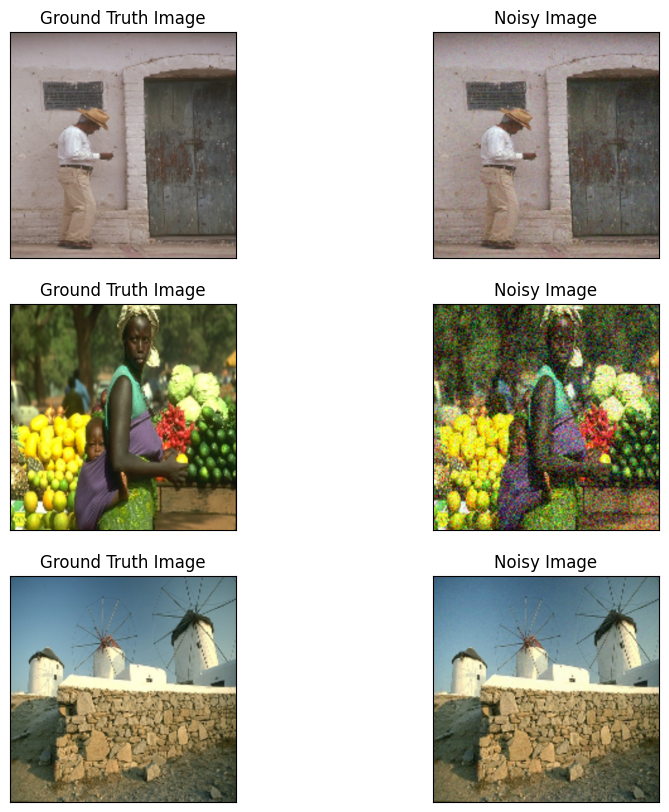

In [9]:
#display few clean-noisy image pairs
sample=df.sample(3)
fig, ax = plt.subplots(len(sample),2,figsize=(10,10))
for i in range(len(sample)):
  img = cv2.imread(sample['ground_truth'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(512,512))
  ax[i][0].imshow(img)
  ax[i][0].get_xaxis().set_visible(False)
  ax[i][0].get_yaxis().set_visible(False)
  ax[i][0].title.set_text("Ground Truth Image")
  
  img = cv2.imread(sample['noisy'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(512,512))
  ax[i][1].imshow(img)
  ax[i][1].get_xaxis().set_visible(False)
  ax[i][1].get_yaxis().set_visible(False)
  ax[i][1].title.set_text("Noisy Image")

### Splitting the dataset into train and test datasets

In [10]:
X=df['noisy']
Y=df['ground_truth']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#Storing the image patches as pickle files

pickle.dump((X_train,y_train),open('train_path.pkl','wb'))
pickle.dump((X_test,y_test),open('test_path.pkl','wb'))


X_train, y_train = pickle.load(open('train_path.pkl', 'rb'))
X_test,y_test = pickle.load(open('test_path.pkl', 'rb'))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(320,)
(320,)
(80,)
(80,)


### Create X_train and y_train

In [11]:
X_train_patches = []
y_train_patches = []
for i in range(len(X_train)):
  path = X_train.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  
  patches_nsy = cv2.resize(img_nsy,(256,256))  #resizing the X_train images

  
  path = y_train.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  patches_gt = cv2.resize(img_gt,(256,256))  #resizing the y_train images

  X_train_patches.append(patches_nsy)
  y_train_patches.append(patches_gt)


  
X_train_patches = np.array(X_train_patches)
y_train_patches = np.array(y_train_patches)
print(X_train_patches.shape)
print(y_train_patches.shape)

(320, 256, 256, 3)
(320, 256, 256, 3)


In [12]:
#Creating patches for X_test and y_test
X_test_patches = []
y_test_patches = []
for i in range(len(X_test)):
  path = X_test.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  patches_nsy = cv2.resize(img_nsy,(256,256))  #resizing the X_test images

  
  path = y_test.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  patches_gt = cv2.resize(img_gt,(256,256))  #resizing the y_test images


  X_test_patches.append(patches_nsy)
  y_test_patches.append(patches_gt)

X_test_patches = np.array(X_test_patches)
y_test_patches = np.array(y_test_patches)

In [13]:
print(X_train_patches.shape)
print(y_train_patches.shape)
print(X_test_patches.shape)
print(y_test_patches.shape)
     

(320, 256, 256, 3)
(320, 256, 256, 3)
(80, 256, 256, 3)
(80, 256, 256, 3)


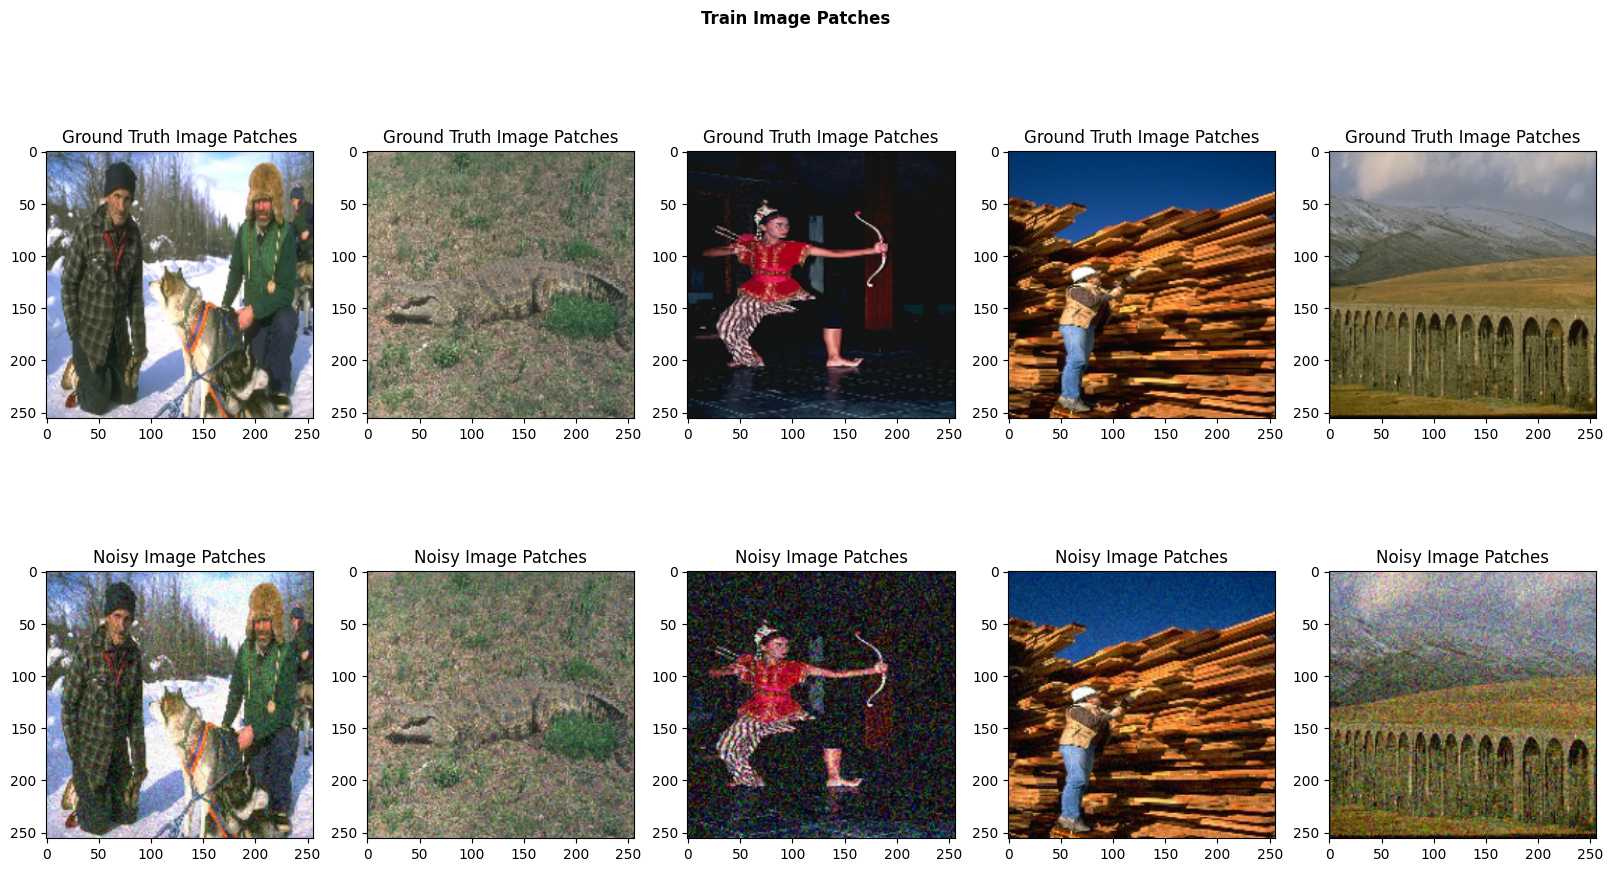

In [14]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, len(X_train)), 5)

fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_train_patches[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_train_patches[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

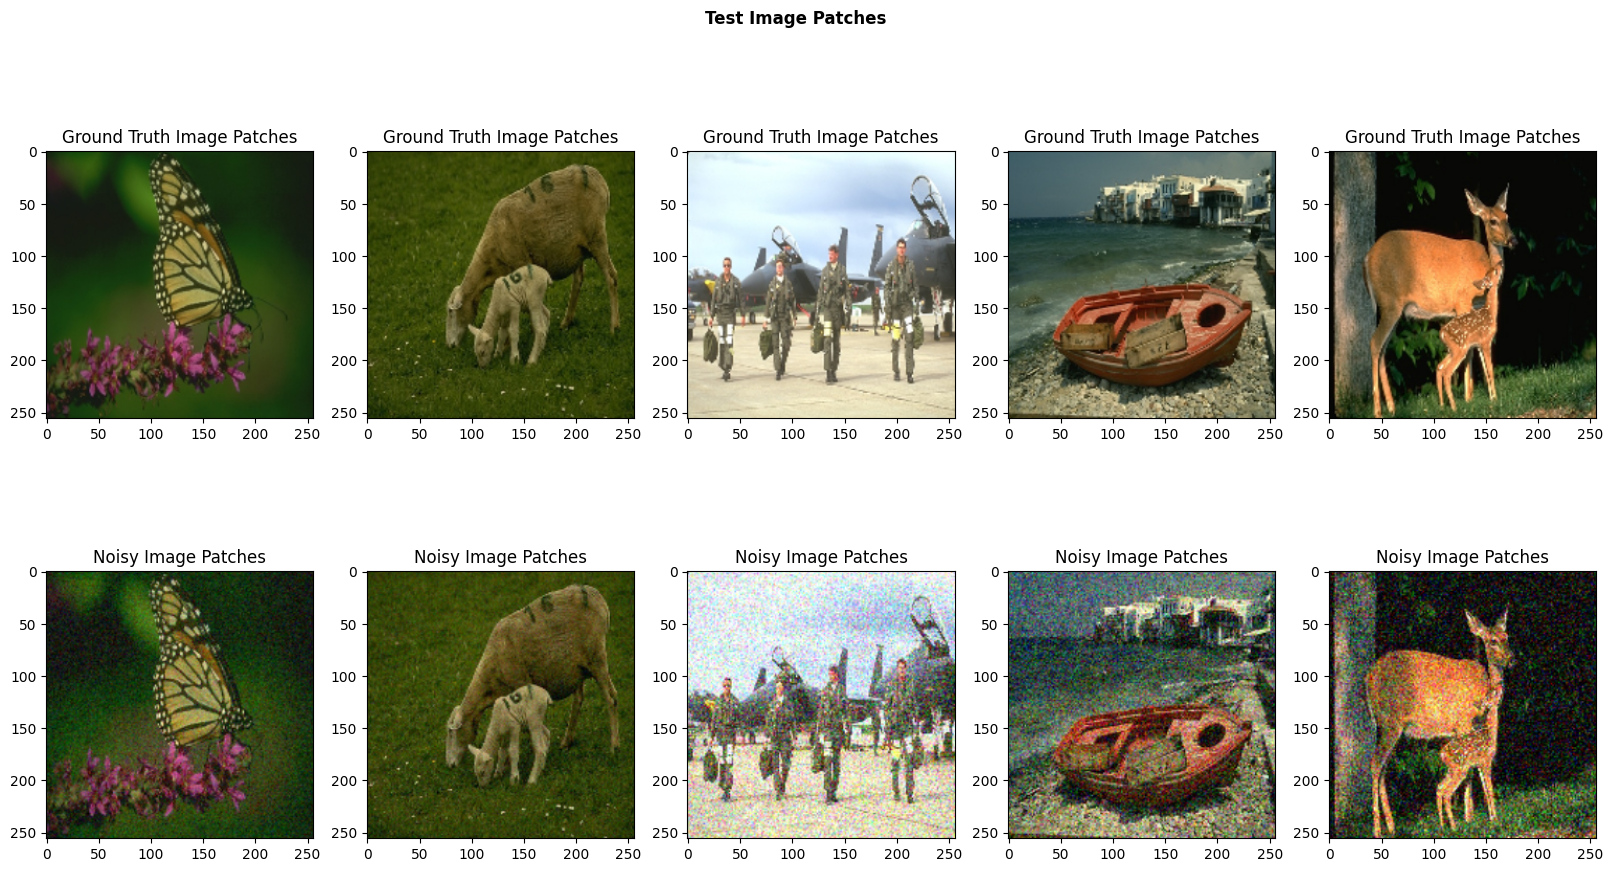

In [15]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, len(X_test)), 5)

fig.suptitle('Test Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_test_patches[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_test_patches[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

In [16]:

print("Total number of image patches on train data : ", (X_train_patches.shape))
print("Total number of image patches on test data : ", (X_test_patches.shape))

Total number of image patches on train data :  (320, 256, 256, 3)
Total number of image patches on test data :  (80, 256, 256, 3)


### Define the dataloader

In [17]:
#normalize the image patches
X_train_patches = X_train_patches.astype("float32") / 255.0
y_train_patches = y_train_patches.astype("float32") / 255.0
X_test_patches = X_test_patches.astype("float32") / 255.0
y_test_patches = y_test_patches.astype("float32") / 255.0

In [18]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, X,y,batch_size=1, shuffle=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))

    def __getitem__(self, i):
        # collect batch data
        batch_x = self.X[i * self.batch_size : (i+1) * self.batch_size]
        batch_y = self.y[i * self.batch_size : (i+1) * self.batch_size]
        
        return tuple((batch_x,batch_y))
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [19]:
batch_size=8
train_dataloader = Dataloder(X_train_patches,y_train_patches, batch_size, shuffle=True)
test_dataloader = Dataloder(X_test_patches,y_test_patches,batch_size, shuffle=True)
print(train_dataloader[0][0].shape)

(8, 256, 256, 3)


In [20]:
class EAM(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)
    
    self.conv1 = Conv2D(64, (3,3), dilation_rate=1,padding='same',activation=tf.keras.layers.LeakyReLU())
    self.conv2 = Conv2D(64, (3,3), dilation_rate=2,padding='same',activation=tf.keras.layers.LeakyReLU()) 

    self.conv3 = Conv2D(64, (3,3), dilation_rate=3,padding='same',activation=tf.keras.layers.LeakyReLU())
    self.conv4 = Conv2D(64, (3,3), dilation_rate=4,padding='same',activation=tf.keras.layers.LeakyReLU())

    self.conv5 = Conv2D(64, (3,3),padding='same',activation=tf.keras.layers.LeakyReLU())

    self.conv6 = Conv2D(64, (3,3),padding='same',activation=tf.keras.layers.LeakyReLU())
    self.conv7 = Conv2D(64, (3,3),padding='same')

    self.conv8 = Conv2D(64, (3,3),padding='same',activation=tf.keras.layers.LeakyReLU())
    self.conv9 = Conv2D(64, (3,3),padding='same',activation=tf.keras.layers.LeakyReLU())
    self.conv10 = Conv2D(64, (1,1),padding='same')

    self.gap = GlobalAveragePooling2D()

    self.conv11 = Conv2D(64, (3,3),padding='same',activation=tf.keras.layers.LeakyReLU())
    self.d1 = tf.keras.layers.Dropout(0.2)
    self.conv12 = Conv2D(64, (3,3),padding='same',activation='sigmoid')

  def call(self,input):
    conv1 = self.conv1(input)
    conv1 = self.conv2(conv1)

    conv2 = self.conv3(input)
    conv2 = self.conv4(conv2)

    concat = concatenate([conv1,conv2])
    conv3 = self.conv5(concat)
    add1 = Add()([input,conv3])

    conv4 = self.conv6(add1)
    conv4 = self.conv7(conv4)
    add2 = Add()([conv4,add1])
    add2 = Activation('relu')(add2)

    conv5 = self.conv8(add2)
    conv5 = self.conv9(conv5)
    # conv5 = self.d2(conv5)
    conv5 = self.conv10(conv5)
    add3 = Add()([add2,conv5])
    add3 = Activation('relu')(add3)

    gap = self.gap(add3)
    gap = Reshape((1,1,64))(gap)
    conv6 = self.conv11(gap)
    conv6 = self.d1(conv6)
    conv6 = self.conv12(conv6)
    
    mul = Multiply()([conv6, add3])
    out = Add()([input,mul]) # This is not included in the reference code
    return out
  



In [21]:
def create_model():
  tf.keras.backend.clear_session()
  input = Input(shape=(256, 256, 3))

  conv1 = Conv2D(64, (3,3),padding='same')(input)
  eam1 = EAM()(conv1)
  eam2 = EAM()(eam1)
  eam3 = EAM()(eam2)
  eam4 = EAM()(eam3) 
  conv2 = Conv2D(3, (3,3),padding='same')(eam4)
  out = Add()([conv2,input])
  RIDNet = Model(input,out)
  return RIDNet


In [22]:
RIDNet=create_model()
RIDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())

In [23]:

checkpoint_path = "training_1/cp.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=True)

In [24]:

history=RIDNet.fit(train_dataloader,
                 epochs=EPOCHS,
                 shuffle=True,
                 validation_data=test_dataloader,
                 callbacks=[model_checkpoint_callback])

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 0.1172
Epoch 1: val_loss improved from inf to 0.00554, saving model to training_1/cp.ckpt
40/40 [==============================] - 110s 2s/step - loss: 0.1172 - val_loss: 0.0055
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.0047
Epoch 2: val_loss improved from 0.00554 to 0.00404, saving model to training_1/cp.ckpt
40/40 [==============================] - 79s 2s/step - loss: 0.0047 - val_loss: 0.0040
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 0.0034
Epoch 3: val_loss improved from 0.00404 to 0.00284, saving model to training_1/cp.ckpt
40/40 [==============================] - 79s 2s/step - loss: 0.0034 - val_loss: 0.0028
Epoch 4/50
40/40 [==============================] - ETA: 0s - loss: 0.0026
Epoch 4: val_loss improved from 0.00284 to 0.00254, saving model to training_1/cp.ckpt
40/40 [==============================] - 79s 2s/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5

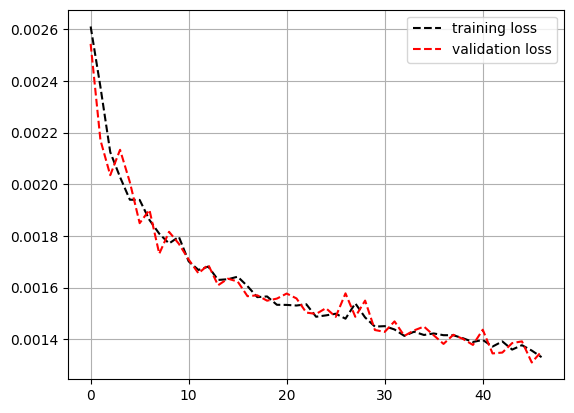

In [25]:
#plot the loss and accuracy plot
plt.plot(history.history['loss'][3:],'k--')
plt.plot(history.history['val_loss'][3:],'r--')
plt.legend(['training loss','validation loss'])
plt.grid()
plt.show()

### Visualize output of the model

In [26]:
#function to display multiple images in subplots
def display_images(list_of_images,list_of_titles=None):
    N=len(list_of_images)
    M=int(np.ceil(N/2))
    figs,ax=plt.subplots(M,2,figsize=(6,6))
    ax=ax.flatten()
    for i in range(len(list_of_images)):
        ax[i].imshow(list_of_images[i])
        if list_of_titles is not None:
            ax[i].title.set_text(list_of_titles[i])
    plt.show()

In [27]:
def predict(img,model,display=False,verbose=True):
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(256,256))
  noisy_patches=img.astype("float32")/255.0
  noisy_patches=tf.expand_dims(noisy_patches,0)
  pred_img=model.predict(noisy_patches,verbose=verbose)
  pred_img=tf.squeeze(pred_img)
  # pred_img=np.reshape(pred_img,(8,8,1,32,32,3))
  # pred_img=unpatchify(pred_img,img.shape)
  if display:
    display_images([img,pred_img])
  return pred_img


1/1 [==============================] - 1s 1s/step


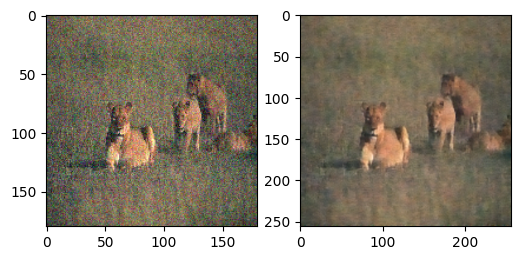

In [28]:
sample=df.sample(1)
img=cv2.imread(sample['noisy'].iloc[0])
img1=predict(img,RIDNet)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
display_images([img,img1])

### calculate PSNR and SSIM 

In [36]:
def psnr_and_ssim(X_test,y_test,model,model_type='Normal',test_68=False):
  psnr_nsy = 0.0
  psnr_de_nsy = 0.0
  ssim_nsy = 0.0
  ssim_de_nsy = 0.0
  psnr_list=[]
  ssim_list=[]
  for i in range(len(X_test)):
    #getting the noisy images
    if test_68:
      path=X_test[i]
    else:
      path = X_test.iloc[i]
    nsy = cv2.imread(path)  
    pred = predict(nsy,model,verbose=False)
    pred=pred.numpy()

    #getting the ground truth images
    if test_68:
      path = y_test[i]
    else:
      path=y_test.iloc[i]
    gt = cv2.imread(path) 

    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    pred=cv2.cvtColor(pred,cv2.COLOR_BGR2GRAY)
    nsy=cv2.cvtColor(nsy,cv2.COLOR_BGR2GRAY)
    #Resizing the images
    gt = cv2.resize(gt,(256,256))
    nsy = cv2.resize(nsy,(256,256))

    #Normalizing the images
    gt = gt.astype("float32") / 255.0
    nsy = nsy.astype("float32") / 255.0

    if i==0:
      print(np.max(gt),np.max(pred),np.max(nsy))
    #Computing psnr and ssim for test images
    psnr_list.append(PSNR(gt,pred))
    # ssim_list.append(ssim(gt,pred,channel_axis=2,data_range=pred.max()-pred.min()))
    ssim_list.append(ssim(gt,pred))
    psnr_nsy += PSNR(gt,nsy)
    psnr_de_nsy += PSNR(gt,pred)
    ssim_nsy += ssim(gt,nsy)
    ssim_de_nsy += ssim(gt,pred)

  psnr_nsy = psnr_nsy/len(X_test)
  psnr_de_nsy = psnr_de_nsy/len(X_test)
  ssim_nsy = ssim_nsy/len(X_test)
  ssim_de_nsy = ssim_de_nsy/len(X_test)
  return psnr_nsy, psnr_de_nsy,ssim_nsy,ssim_de_nsy,psnr_list,ssim_list

1.0 0.9941649 1.0
PSNR before denoising : 14.697635472596797
PSNR after denoising : 13.42849502762139
SSIM before denoising : 0.8018078440948647
SSIM after denoising : 0.9059513345867425


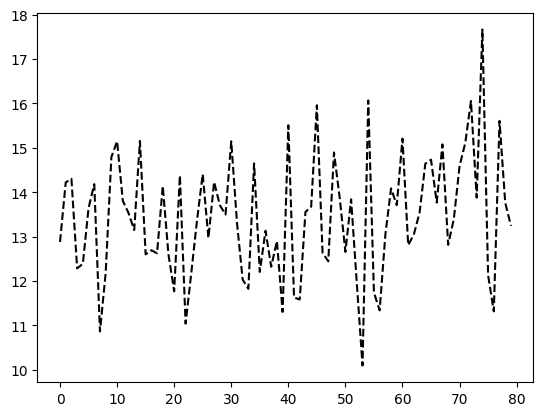

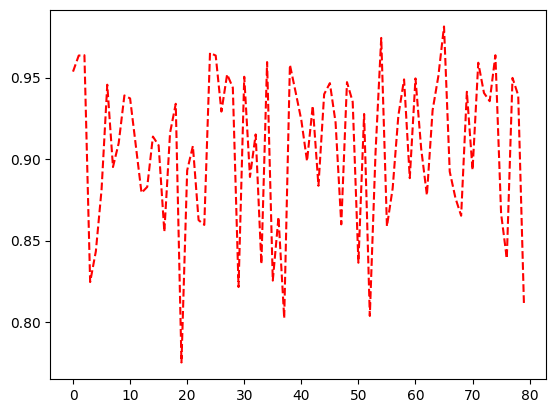

In [37]:

psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy,psnr_list,ssim_list = psnr_and_ssim(X_test,y_test,RIDNet)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)
plt.plot(psnr_list,'k--')
plt.show()
plt.plot(ssim_list,'r--')
plt.show()

In [31]:
!zip -r checkpoint_rid.zip /content/training_1

  adding: content/training_1/ (stored 0%)
  adding: content/training_1/checkpoint (deflated 38%)
  adding: content/training_1/cp.ckpt.data-00000-of-00001 (deflated 16%)
  adding: content/training_1/cp.ckpt.index (deflated 79%)


### Load from checkpoint and check

1.0 1.002696 1.0
PSNR before denoising : 14.697635472596797
PSNR after denoising : 13.523110000993256
SSIM before denoising : 0.8018078440948647
SSIM after denoising : 0.9065562004945305


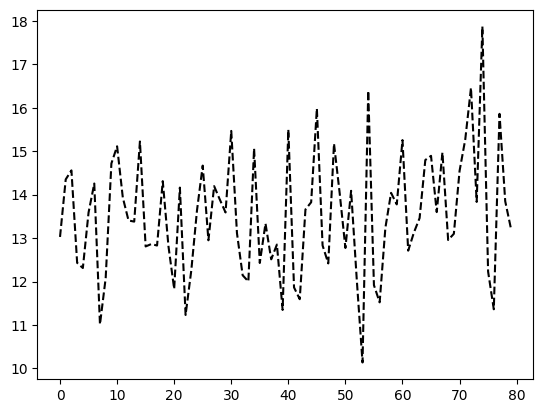

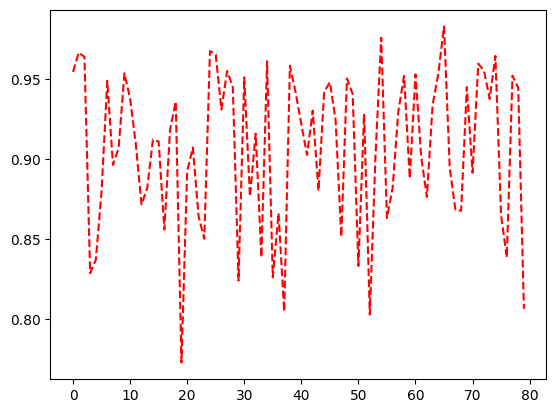

In [38]:
model_1 = create_model()
model_1.load_weights(checkpoint_path)
psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy,psnr_list,ssim_list = psnr_and_ssim(X_test,y_test,model_1)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)
plt.plot(psnr_list,'k--')
plt.show()
plt.plot(ssim_list,'r--')
plt.show()

### check with set68 data

0.9882353 1.0095294 0.9882353
PSNR before denoising : 15.8359271282966
PSNR after denoising --> mean:14.0113, variance:1.2510
SSIM before denoising : 0.9244318859619671
SSIM after denoising --> mean:0.9369, variance:0.0174


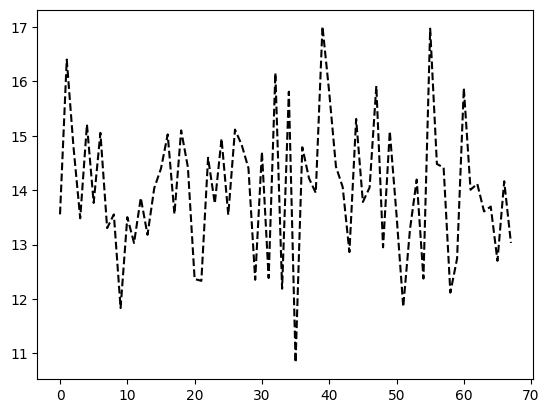

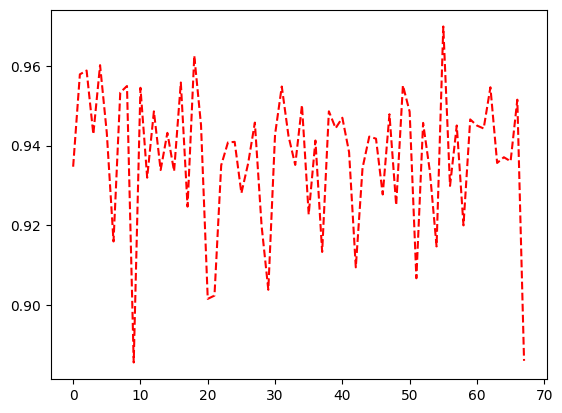

In [39]:

test_set_path='/content/drive/MyDrive/EE6310_course_project/noisy15/*.png'
original_file_path='/content/drive/MyDrive/EE6310_course_project/original_png/'
file_names=glob(test_set_path)
X_test_68=[]
y_test_68=[]
for file in file_names:
  input_name=file.split('/')[-1]
  X_test_68.append(file)
  y_test_68.append(original_file_path+input_name)

psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy,psnr_list,ssim_list = psnr_and_ssim(X_test_68,y_test_68,model_1,test_68=True)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising --> mean:{:.4f}, variance:{:.4f}'.format(np.mean(psnr_list),np.std(psnr_list)))
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising --> mean:{:.4f}, variance:{:.4f}'.format(np.mean(ssim_list),np.std(ssim_list)))

plt.plot(psnr_list,'k--')
plt.show()
plt.plot(ssim_list,'r--')
plt.show()

1.0 1.0573608 1.0
PSNR before denoising : 13.674298780157313
PSNR after denoising --> mean:13.5859, variance:1.0687
SSIM before denoising : 0.8271236718525252
SSIM after denoising --> mean:0.9101, variance:0.0169


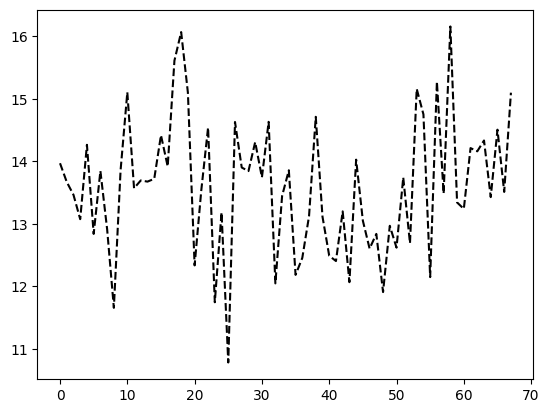

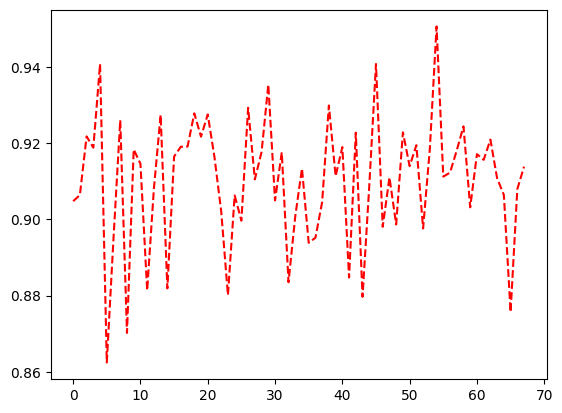

In [40]:

test_set_path='/content/drive/MyDrive/EE6310_course_project/noisy25/*.png'
original_file_path='/content/drive/MyDrive/EE6310_course_project/original_png/'
file_names=glob(test_set_path)
X_test_68=[]
y_test_68=[]
for file in file_names:
  input_name=file.split('/')[-1]
  X_test_68.append(file)
  y_test_68.append(original_file_path+input_name)

psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy,psnr_list,ssim_list = psnr_and_ssim(X_test_68,y_test_68,model_1,test_68=True)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising --> mean:{:.4f}, variance:{:.4f}'.format(np.mean(psnr_list),np.std(psnr_list)))
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising --> mean:{:.4f}, variance:{:.4f}'.format(np.mean(ssim_list),np.std(ssim_list)))
plt.plot(psnr_list,'k--')
plt.show()
plt.plot(ssim_list,'r--')
plt.show()